In [1]:
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("../derived/final_stats_data.csv",low_memory=False)

In [3]:
df['delivery_type'] = df['total_run'].astype(str)

In [4]:
df.drop(['non-striker', 'extra_type',
       'non_boundary', 'player_out', 'kind',
       'fielders_involved', 'City','MatchNumber','SuperOver',
       'WonBy', 'Margin', 'method','Player_of_Match',
       'Team1Players', 'Team2Players', 'Umpire1', 'Umpire2',
       'WinningTeam', 'Team2','Date','Team1','Venue','TossWinner','batter','bowler'], axis = 1, inplace = True)

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'df' is your DataFrame
columns_to_encode = ['Season', 'BattingTeam', 'BowlingTeam','delivery_type','TossDecision']

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform on the training data
encoder.fit(df[columns_to_encode])

# Transform the specified categorical columns to one-hot encoded representation
one_hot_encoded = encoder.transform(df[columns_to_encode])

# Concatenate the one-hot encoded features with the original DataFrame
df = pd.concat([df, pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(columns_to_encode))], axis=1)

# Drop the original categorical columns
df = df.drop(columns_to_encode, axis=1)

In [6]:
# Specify the columns to scale
columns_to_scale = ['strike_rate_x', 'batting_average', 'strike_rate_y', 'bowling_average',
                    'economy','runs_conceded','runs_scored','balls_faced','balls_bowled',
                    'batter_matches_played','0s_scored', '1s_scored', '2s_scored', '4s_scored', '6s_scored',
                     'high_score', '25_scored', '50_scored', '75_scored', '100_scored','0_wickets_taken', '1_wickets_taken',
                    '2_wickets_taken', '3_wickets_taken', '4_wickets_taken', '5_wickets_taken','6_wickets_taken',
                    'bowler_matches_played','wickets_taken','4s_conceded','6s_conceded', '0s_conceded', '1s_conceded',
                    '2s_conceded', 'highest_conceded',]

In [7]:
# Replace infinite or too large values with the median
df[columns_to_scale] = df[columns_to_scale].replace([np.inf, -np.inf], np.nan)
df[columns_to_scale] = df[columns_to_scale].fillna(df[columns_to_scale].median())

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn.functional as F


In [34]:
class MyLSTMWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTMWithSoftmax, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] # Extract the output of the last time step
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = F.softmax(out, dim=1)  # Apply softmax activation
        return out

In [35]:
model = MyLSTMWithSoftmax(96, 64, 8)

In [36]:
model.load_state_dict(torch.load('../model/cric_model_2nd.pth'))

<All keys matched successfully>

In [13]:
unique_ids = df['ID'].unique()

id_dataframes = {}

for unique_id in unique_ids:
    id_dataframes[unique_id] = df[df['ID'] == unique_id]

In [14]:
unique_ids

array([1312200, 1312199, 1312198, 1312197, 1304116, 1304115, 1304114,
       1304113, 1304112, 1304111, 1304110, 1304109, 1304108, 1304107,
       1304106, 1304105, 1304104, 1304103, 1304102, 1304101, 1304100,
       1304099, 1304098, 1304097, 1304096, 1304095, 1304094, 1304093,
       1304092, 1304091, 1304090, 1304089, 1304088, 1304087, 1304086,
       1304085, 1304084, 1304083, 1304082, 1304081, 1304080, 1304079,
       1304078, 1304077, 1304076, 1304075, 1304074, 1304073, 1304072,
       1304071, 1304070, 1304069, 1304068, 1304067, 1304066, 1304065,
       1304064, 1304063, 1304062, 1304061, 1304060, 1304059, 1304058,
       1304057, 1304056, 1304055, 1304054, 1304053, 1304052, 1304051,
       1304050, 1304049, 1304048, 1304047, 1254117, 1254116, 1254115,
       1254114, 1254113, 1254112, 1254111, 1254110, 1254109, 1254108,
       1254107, 1254106, 1254105, 1254104, 1254103, 1254102, 1254101,
       1254100, 1254099, 1254098, 1254097, 1254096, 1254095, 1254094,
       1254093, 1254

In [15]:
id_dataframes[unique_ids[0]].iloc[:6].head()

,ID,innings,overs,ballnumber,batsman_run,extras_run,total_run,isWicketDelivery,batter_matches_played,runs_scored,dismissals,balls_faced,0s_scored,1s_scored,2s_scored,4s_scored,6s_scored,high_score,25_scored,50_scored,75_scored,100_scored,strike_rate_x,batting_average,notout,explosivity_rating,0_wickets_taken,1_wickets_taken,2_wickets_taken,3_wickets_taken,4_wickets_taken,5_wickets_taken,6_wickets_taken,bowler_matches_played,runs_conceded,extras_runs_conceded,wickets_taken,balls_bowled,4s_conceded,6s_conceded,0s_conceded,1s_conceded,2s_conceded,highest_conceded,strike_rate_y,bowling_average,economy,total_runs_conceded,target,current_score,balls_left,wickets_left,runs_left,Season_2008,Season_2009,Season_2010,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018,Season_2019,Season_2020,Season_2021,Season_2022,BattingTeam_Chennai Super Kings,BattingTeam_Deccan Chargers,BattingTeam_Delhi Capitals,BattingTeam_Gujarat Lions,BattingTeam_Gujarat Titans,BattingTeam_Kochi Tuskers Kerala,BattingTeam_Kolkata Knight Riders,BattingTeam_Lucknow Super Giants,BattingTeam_Mumbai Indians,BattingTeam_Pune Warriors,BattingTeam_Punjab Kings,BattingTeam_Rajasthan Royals,BattingTeam_Rising Pune Supergiant,BattingTeam_Royal Challengers Bangalore,BattingTeam_Sunrisers Hyderabad,BowlingTeam_Chennai Super Kings,BowlingTeam_Deccan Chargers,BowlingTeam_Delhi Capitals,BowlingTeam_Gujarat Lions,BowlingTeam_Gujarat Titans,BowlingTeam_Kochi Tuskers Kerala,BowlingTeam_Kolkata Knight Riders,BowlingTeam_Lucknow Super Giants,BowlingTeam_Mumbai Indians,BowlingTeam_Pune Warriors,BowlingTeam_Punjab Kings,BowlingTeam_Rajasthan Royals,BowlingTeam_Rising Pune Supergiant,BowlingTeam_Royal Challengers Bangalore,BowlingTeam_Sunrisers Hyderabad,delivery_type_0,delivery_type_1,delivery_type_2,delivery_type_3,delivery_type_4,delivery_type_5,delivery_type_6,delivery_type_7,TossDecision_bat,TossDecision_field
0,1312200,1,0,1,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,0,119,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1312200,1,0,2,0,1,1,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,1,118,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1312200,1,0,3,1,0,1,0,0.354545,0.423398,69,0.366086,0.398429,0.284854,0.350404,0.391618,0.375000,0.708571,0.292308,0.264151,0.352941,0.833333,0.369930,0.450593,10,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,2,117,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1312200,1,0,4,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.1965

In [225]:
selected_match_id = 1304061

In [226]:
selected_match_df = id_dataframes[selected_match_id]
selected_match_df.head(5)

,ID,innings,overs,ballnumber,batsman_run,extras_run,total_run,isWicketDelivery,batter_matches_played,runs_scored,dismissals,balls_faced,0s_scored,1s_scored,2s_scored,4s_scored,6s_scored,high_score,25_scored,50_scored,75_scored,100_scored,strike_rate_x,batting_average,notout,explosivity_rating,0_wickets_taken,1_wickets_taken,2_wickets_taken,3_wickets_taken,4_wickets_taken,5_wickets_taken,6_wickets_taken,bowler_matches_played,runs_conceded,extras_runs_conceded,wickets_taken,balls_bowled,4s_conceded,6s_conceded,0s_conceded,1s_conceded,2s_conceded,highest_conceded,strike_rate_y,bowling_average,economy,total_runs_conceded,target,current_score,balls_left,wickets_left,runs_left,Season_2008,Season_2009,Season_2010,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018,Season_2019,Season_2020,Season_2021,Season_2022,BattingTeam_Chennai Super Kings,BattingTeam_Deccan Chargers,BattingTeam_Delhi Capitals,BattingTeam_Gujarat Lions,BattingTeam_Gujarat Titans,BattingTeam_Kochi Tuskers Kerala,BattingTeam_Kolkata Knight Riders,BattingTeam_Lucknow Super Giants,BattingTeam_Mumbai Indians,BattingTeam_Pune Warriors,BattingTeam_Punjab Kings,BattingTeam_Rajasthan Royals,BattingTeam_Rising Pune Supergiant,BattingTeam_Royal Challengers Bangalore,BattingTeam_Sunrisers Hyderabad,BowlingTeam_Chennai Super Kings,BowlingTeam_Deccan Chargers,BowlingTeam_Delhi Capitals,BowlingTeam_Gujarat Lions,BowlingTeam_Gujarat Titans,BowlingTeam_Kochi Tuskers Kerala,BowlingTeam_Kolkata Knight Riders,BowlingTeam_Lucknow Super Giants,BowlingTeam_Mumbai Indians,BowlingTeam_Pune Warriors,BowlingTeam_Punjab Kings,BowlingTeam_Rajasthan Royals,BowlingTeam_Rising Pune Supergiant,BowlingTeam_Royal Challengers Bangalore,BowlingTeam_Sunrisers Hyderabad,delivery_type_0,delivery_type_1,delivery_type_2,delivery_type_3,delivery_type_4,delivery_type_5,delivery_type_6,delivery_type_7,TossDecision_bat,TossDecision_field
14279,1304061,1,0,1,3,0,3,0,0.277273,0.238471,60,0.208201,0.221466,0.164891,0.159030,0.271676,0.151786,0.565714,0.138462,0.226415,0.117647,0.000000,0.366207,0.291856,2,0.23,0.125,0.138889,0.139535,0.411765,0.333333,0.0,0.0,0.206704,0.264533,75,0.2657,0.218692,0.250591,0.227273,0.219858,0.180571,0.245353,0.724638,0.1671,0.154821,0.226522,1199,150,3,119,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14280,1304061,1,0,2,0,0,0,0,0.709091,0.880687,140,0.802100,0.832984,0.676702,0.892183,0.809249,0.622024,0.720000,0.492308,1.000000,0.764706,0.666667,0.351296,0.461932,17,0.19,0.125,0.138889,0.139535,0.411765,0.333333,0.0,0.0,0.206704,0.264533,75,0.2657,0.218692,0.250591,0.227273,0.219858,0.180571,0.245353,0.724638,0.1671,0.154821,0.226522,1199,150,3,118,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14281,1304061,1,0,3,0,0,0,0,0.709091,0.880687,140,0.802100,0.832984,0.676702,0.892183,0.809249,0.622024,0.720000,0.492308,1.000000,0.764706,0.666667,0.351296,0.461932,17,0.19,0.125,0.138889,0.139535,0.411765,0.333333,0.0,0.0,0.206704,0.264533,75,0.2657,0.218692,0.250591,0.227273,0.219858,0.180571,0.245353,0.724638,0.1671,0.154821,0.226522,1199,150,3,117,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14282,1304061,1,0,4,1,0,1,0,0.709091,0.880687,140,0.802100,0.832984,0.676702,0.892183,0.809249,0.622024,0.720000,0.492308,1.000000,0.764706,0.666667,0.351296,0.461932,17,0.19,0.125,0.138889,0.139535,0.411765,0.333333,0.0,0.0,0.206704,0.264533,75,0.2657,0.218692,0.250591,0.227273,0.219858,0.180571,0.245353,0.724638,0.1671,0.15

In [227]:
features = selected_match_df[['innings', 'overs', 'ballnumber',
                               'isWicketDelivery', 'batter_matches_played', 'runs_scored', 'dismissals',
                               'balls_faced', '0s_scored', '1s_scored', '2s_scored', '4s_scored', '6s_scored',
                               'high_score', '25_scored', '50_scored', '75_scored', '100_scored', 'strike_rate_x',
                               'batting_average', 'notout', 'explosivity_rating', '0_wickets_taken', '1_wickets_taken',
                               '2_wickets_taken', '3_wickets_taken', '4_wickets_taken', '5_wickets_taken',
                               '6_wickets_taken', 'bowler_matches_played', 'runs_conceded', 'extras_runs_conceded',
                               'wickets_taken', 'balls_bowled', '4s_conceded', '6s_conceded', '0s_conceded',
                               '1s_conceded', '2s_conceded', 'highest_conceded', 'strike_rate_y', 'bowling_average',
                               'economy', 'total_runs_conceded', 'target', 'current_score', 'balls_left',
                               'wickets_left', 'runs_left', 'Season_2008', 'Season_2009', 'Season_2010', 'Season_2011',
                               'Season_2012', 'Season_2013', 'Season_2014', 'Season_2015', 'Season_2016', 'Season_2017',
                               'Season_2018', 'Season_2019', 'Season_2020', 'Season_2021', 'Season_2022',
                               'BattingTeam_Chennai Super Kings', 'BattingTeam_Deccan Chargers', 'BattingTeam_Delhi Capitals',
                               'BattingTeam_Gujarat Lions', 'BattingTeam_Gujarat Titans', 'BattingTeam_Kochi Tuskers Kerala',
                               'BattingTeam_Kolkata Knight Riders', 'BattingTeam_Lucknow Super Giants', 'BattingTeam_Mumbai Indians',
                               'BattingTeam_Pune Warriors', 'BattingTeam_Punjab Kings', 'BattingTeam_Rajasthan Royals',
                               'BattingTeam_Rising Pune Supergiant', 'BattingTeam_Royal Challengers Bangalore',
                               'BattingTeam_Sunrisers Hyderabad', 'BowlingTeam_Chennai Super Kings', 'BowlingTeam_Deccan Chargers',
                               'BowlingTeam_Delhi Capitals', 'BowlingTeam_Gujarat Lions', 'BowlingTeam_Gujarat Titans',
                               'BowlingTeam_Kochi Tuskers Kerala', 'BowlingTeam_Kolkata Knight Riders', 'BowlingTeam_Lucknow Super Giants',
                               'BowlingTeam_Mumbai Indians', 'BowlingTeam_Pune Warriors', 'BowlingTeam_Punjab Kings',
                               'BowlingTeam_Rajasthan Royals', 'BowlingTeam_Rising Pune Supergiant',
                               'BowlingTeam_Royal Challengers Bangalore', 'BowlingTeam_Sunrisers Hyderabad',
                               'TossDecision_bat', 'TossDecision_field']]

In [183]:
features.head(5)

,innings,overs,ballnumber,isWicketDelivery,batter_matches_played,runs_scored,dismissals,balls_faced,0s_scored,1s_scored,2s_scored,4s_scored,6s_scored,high_score,25_scored,50_scored,75_scored,100_scored,strike_rate_x,batting_average,notout,explosivity_rating,0_wickets_taken,1_wickets_taken,2_wickets_taken,3_wickets_taken,4_wickets_taken,5_wickets_taken,6_wickets_taken,bowler_matches_played,runs_conceded,extras_runs_conceded,wickets_taken,balls_bowled,4s_conceded,6s_conceded,0s_conceded,1s_conceded,2s_conceded,highest_conceded,strike_rate_y,bowling_average,economy,total_runs_conceded,target,current_score,balls_left,wickets_left,runs_left,Season_2008,Season_2009,Season_2010,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018,Season_2019,Season_2020,Season_2021,Season_2022,BattingTeam_Chennai Super Kings,BattingTeam_Deccan Chargers,BattingTeam_Delhi Capitals,BattingTeam_Gujarat Lions,BattingTeam_Gujarat Titans,BattingTeam_Kochi Tuskers Kerala,BattingTeam_Kolkata Knight Riders,BattingTeam_Lucknow Super Giants,BattingTeam_Mumbai Indians,BattingTeam_Pune Warriors,BattingTeam_Punjab Kings,BattingTeam_Rajasthan Royals,BattingTeam_Rising Pune Supergiant,BattingTeam_Royal Challengers Bangalore,BattingTeam_Sunrisers Hyderabad,BowlingTeam_Chennai Super Kings,BowlingTeam_Deccan Chargers,BowlingTeam_Delhi Capitals,BowlingTeam_Gujarat Lions,BowlingTeam_Gujarat Titans,BowlingTeam_Kochi Tuskers Kerala,BowlingTeam_Kolkata Knight Riders,BowlingTeam_Lucknow Super Giants,BowlingTeam_Mumbai Indians,BowlingTeam_Pune Warriors,BowlingTeam_Punjab Kings,BowlingTeam_Rajasthan Royals,BowlingTeam_Rising Pune Supergiant,BowlingTeam_Royal Challengers Bangalore,BowlingTeam_Sunrisers Hyderabad,TossDecision_bat,TossDecision_field
977,1,0,1,0,0.072727,0.038842,16,0.042987,0.044503,0.043539,0.053908,0.021676,0.026786,0.291429,0.030769,0.018868,0.000000,0.0,0.287844,0.178267,1,0.11,0.104167,0.013889,0.023256,0.058824,0.0,0.0,0.0,0.067039,0.049188,6,0.028986,0.037861,0.026005,0.068182,0.030303,0.038286,0.048327,0.362319,0.27381,0.263889,0.241898,215,158,1,119,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
978,1,0,2,0,0.150000,0.103219,29,0.097464,0.105236,0.084298,0.102426,0.092486,0.074405,0.428571,0.138462,0.037736,0.058824,0.0,0.338235,0.261364,5,0.18,0.104167,0.013889,0.023256,0.058824,0.0,0.0,0.0,0.067039,0.049188,6,0.028986,0.037861,0.026005,0.068182,0.030303,0.038286,0.048327,0.362319,0.27381,0.263889,0.241898,215,158,1,118,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
979,1,0,3,0,0.150000,0.103219,29,0.097464,0.105236,0.084298,0.102426,0.092486,0.074405,0.428571,0.138462,0.037736,0.058824,0.0,0.338235,0.261364,5,0.18,0.104167,0.013889,0.023256,0.058824,0.0,0.0,0.0,0.067039,0.049188,6,0.028986,0.037861,0.026005,0.068182,0.030303,0.038286,0.048327,0.362319,0.27381,0.263889,0.241898,215,158,1,117,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
980,1,0,4,0,0.150000,0.103219,29,0.097464,0.105236,0.084298,0.102426,0.092486,0.074405,0.428571,0.138462,0.037736,0.058824,0.0,0.338235,0.261364,5,0.18,0.104167,0.013889,0.023256,0.058824,0.0,0.0,0.0,0.067039,0.049188,6,0.028986,0.037861,0.026005,0.068182,0.030303,0.038286,0.048327,0.362319,0.27381,0.263889,0.241898,215,158,1,116,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
981,1,0,5,0,0.150000,0.103219,29,0.097464,0.105236,0.084298,0.102426,0.092486,0.074405,0.428571,0.138462,0.037736,0.058824,0.0,0.338

In [228]:
features_tensor = torch.tensor(features.to_numpy().reshape(1,-1,96).astype(np.float32))

In [194]:
features_tensor.shape

torch.Size([1, 247, 96])

In [229]:
model.eval()

MyLSTMWithSoftmax(
  (lstm): LSTM(96, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=8, bias=True)
)

# iterate


In [48]:
# predictions = []

# for i in range(features_tensor.size(1)):
#     current_input = features_tensor[:,i:i+1,:]
    
#     with torch.no_grad():
#         out = model(current_input)
#         y_pred = F.softmax(out, dim=1)
#         our_prediction = torch.argmax(y_pred, dim=1).item()
    
#     predictions.append(our_prediction)

# print(predictions)

In [43]:
# predictions = []
# sequence_length = 6
# if features_tensor.size(1) < sequence_length:
#     raise ValueError("Insufficient rows in features_tensor for sequence prediction.")
# for i in range(features_tensor.size(1) - sequence_length + 1):
#     current_input = features_tensor[:, i:i+sequence_length, :]
    
#     with torch.no_grad():
#         out = model(current_input)
#         # temperature = 5.0  # Adjust as needed
#         # scaled_logits = out / temperature
#         y_pred = F.softmax(out, dim=1)
#         our_prediction = torch.argmax(y_pred, dim=1).item()
    
#     predictions.append(our_prediction)

# print(predictions)

[4, 4, 4, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 1, 4, 4, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 6, 4, 6, 4, 4, 4, 6, 6, 4, 4, 4, 6, 6, 6, 6, 4, 6, 4, 4, 4, 4, 4, 1, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1]


In [49]:
# # Create a DataLoader with batch size 1
# single_match_loader = DataLoader(TensorDataset(features_tensor), batch_size=1, shuffle=False)

In [50]:
# class_mapping = {0: 'delivery_type_0', 1: 'delivery_type_1', 2: 'delivery_type_2',
#                  3: 'delivery_type_3',
#                  4: 'delivery_type_4',5: 'delivery_type_5',
#                  6: 'delivery_type_6',7: 'delivery_type_7'}

In [51]:
# predictions = []

# with torch.no_grad():
#     for inputs in single_match_loader:
#         print(inputs[0].shape)
#         out = model(inputs[0])
#         # print(out)
#         y_pred = F.softmax(out,dim=1)
#         # print(y_pred[0])
#         our_predictions = torch.argmax(y_pred, dim=1)
#         print(our_predictions)
#         predicted_class = class_mapping[our_predictions.item()]
#         print(predicted_class)
#         assert(False)

In [39]:
# predictions = []
# previous_prediction = None

# # Assuming features_tensor contains the entire match data
# for i in range(features_tensor.size(1)):  # Iterate through each ball in the match
#     current_input = features_tensor[:, i:i+1, :]

#     if previous_prediction is not None:
#         # Update the input tensor with the previous prediction
#         current_input[0, 0, -1] = previous_prediction.item()

#     with torch.no_grad():
#         out = model(current_input)
#         y_pred = F.softmax(out, dim=1)
#         our_prediction = torch.argmax(y_pred, dim=1).item()

#     # Save the prediction and update the previous prediction for the next iteration
#     predictions.append(our_prediction)
#     previous_prediction = torch.tensor(our_prediction, dtype=torch.float32)

# # Now 'predictions' contains the predicted outcomes for each ball in the match
# print(predictions)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 6, 6, 4, 6, 4, 4, 4, 6, 6, 4, 4, 4, 6, 6, 6, 6, 4, 6, 1, 1, 1, 1, 1, 1, 4, 6, 6, 6, 4, 4, 1, 1, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [52]:
# sequence_length = 6
# predictions = []

# model.eval()

# with torch.no_grad():
#     for i in range(features_tensor.size(1)):
#         # Determine the start index of the sequence
#         start_idx = max(0, i - sequence_length + 1)
#         end_idx = i + 1  # Include the current row

#         # Extract the current sequence, padding if necessary
#         current_sequence = features_tensor[:, start_idx:end_idx, :]

#         # If the sequence is shorter than sequence_length, pad with zeros
#         if current_sequence.size(1) < sequence_length:
#             pad_size = sequence_length - current_sequence.size(1)
#             current_sequence = F.pad(current_sequence, (0, 0, pad_size, 0), value=0)


#         # Perform inference
#         out = model(current_sequence)
#         y_pred = F.softmax(out, dim=1)
#         our_prediction = torch.argmax(y_pred, dim=1).item()

#         predictions.append(our_prediction)

# print(predictions)

[4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 1, 4, 4, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 6, 4, 6, 4, 4, 4, 6, 6, 4, 4, 4, 6, 6, 6, 6, 4, 6, 4, 4, 4, 4, 4, 1, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1]


In [230]:
import random
predictions = []

# Assuming features_tensor contains the entire match data
for i in range(features_tensor.size(1)):  # Iterate through each ball in the match
    current_input = features_tensor[:, i:i+6, :]

    # print(current_input.shape) #good

    # if previous_prediction is not None:
    #     # Update the input tensor with the previous prediction
    #     current_input[0, 0, -1] = previous_prediction.item()
    #     print(current_input.shape)
    #     assert(False)

    with torch.no_grad():
        out = model(current_input)
        y_pred = F.softmax(out, dim=1)
        our_predictions = torch.argmax(y_pred, dim=1).item()
        if our_predictions in [4, 6]:
            if random.random() < 0.6:
                our_predictions -= 2
        if our_predictions in [0]:
            if random.random() < 0.6:
                our_predictions += 1
            # if random.random() < 0.2:
            #     our_predictions -= 2
        # our_predictions = max(our_predictions-1, 0)
        
        # our_prediction = torch.multinomial(F.softmax(y_pred, dim=0), 1).item()
        # our_predictions = torch.max(our_predictions-1, torch.tensor(0.))
        # print(our_predictions)
        # our_predictions = np.max(our_prediction-1, 0)
        # print(our_prediction)
        # print(F.softmax(y_pred, dim=1))
        # assert(False)

    # Save the prediction and update the previous prediction for the next iteration
    predictions.append(our_predictions)
    
    

# Now 'predictions' contains the predicted outcomes for each ball in the match
print(predictions)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 4, 4, 4, 4, 6, 4, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 6, 6, 4, 4, 6, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 6, 4, 6, 6, 4, 4, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 4, 4, 4, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 6, 4, 4, 6, 4, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 6, 4, 4, 6, 6, 1, 1, 1, 1, 1, 1, 1, 6, 6, 4, 4, 6, 4]


In [196]:
len(predictions)

247

In [221]:
sum(predictions)/2

177.0

# Graph Output


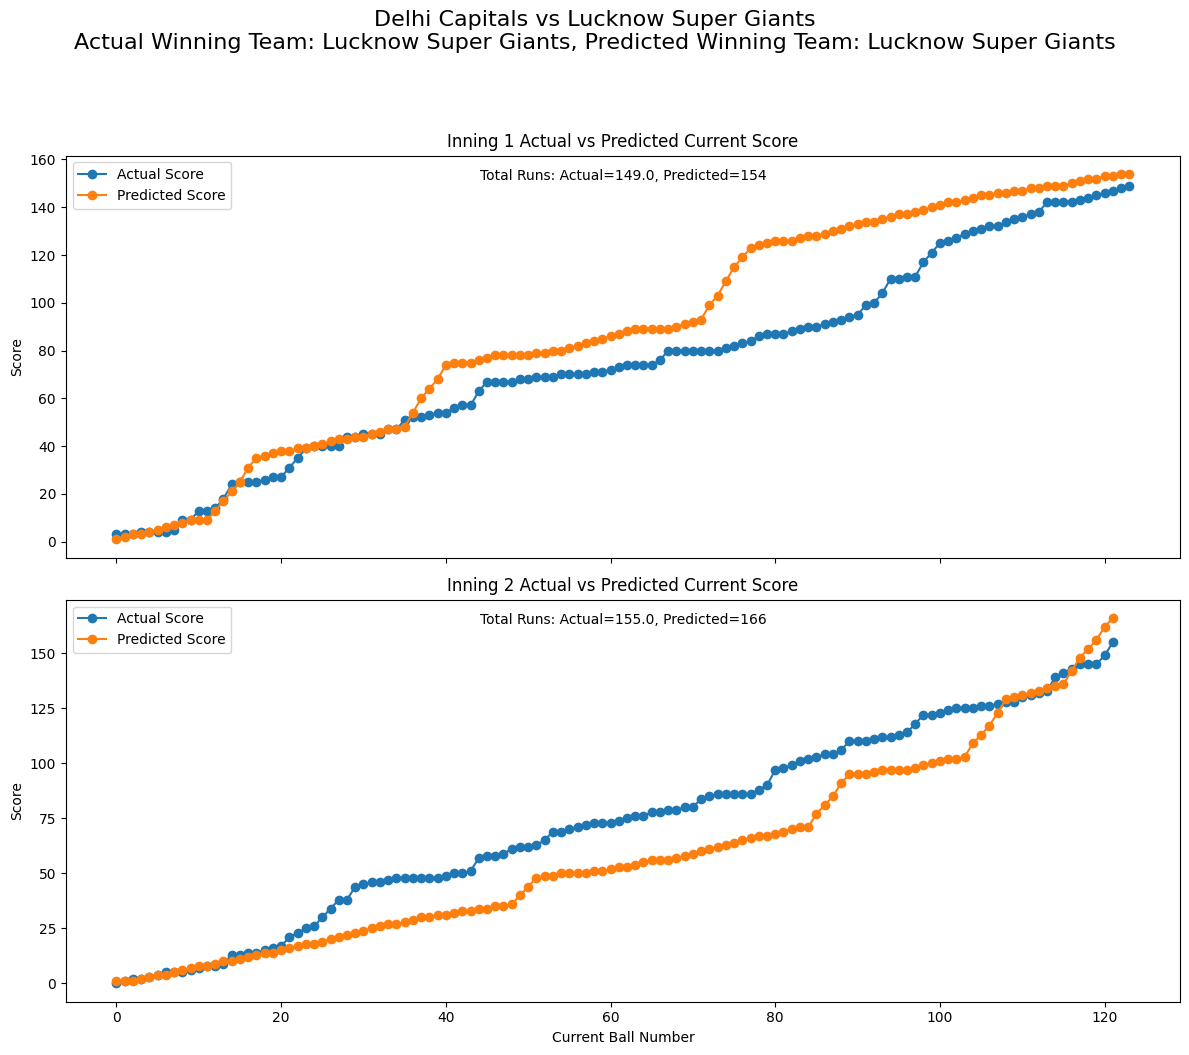

In [231]:

predicted_selected_match_df = selected_match_df.copy()
predicted_selected_match_df['predicted_outcome'] = predictions

column_mapping = {
'delivery_type_0': 0,
'delivery_type_1': 1,
'delivery_type_2': 2,
'delivery_type_3': 3,
'delivery_type_4': 4,
'delivery_type_5': 5,
'delivery_type_6': 6,
'delivery_type_7': 7,
}
delivery_type_columns = ['delivery_type_0', 'delivery_type_1', 'delivery_type_2',
'delivery_type_3', 'delivery_type_4',
'delivery_type_5', 'delivery_type_6', 'delivery_type_7']
predicted_selected_match_df['actual_outcome'] = (
    predicted_selected_match_df[delivery_type_columns].apply(lambda row: sum(row[col] * column_mapping[col] for col in delivery_type_columns), axis=1)
)

predicted_selected_match_df['predicted_current_score'] = predicted_selected_match_df.groupby(['ID', 'innings'])['predicted_outcome'].cumsum()

# Reset the index if needed

predicted_selected_match_df = predicted_selected_match_df.reset_index(drop=True)

predicted_selected_match_df['current_ball_number'] = predicted_selected_match_df.groupby('innings').cumcount()

import matplotlib.pyplot as plt

# Separate data for each inning
inning1_data = predicted_selected_match_df[predicted_selected_match_df['innings'] == 1]
inning2_data = predicted_selected_match_df[predicted_selected_match_df['innings'] == 2]


inning1_actual_total_run = inning1_data['actual_outcome'].sum()
inning1_predicted_total_run = inning1_data['predicted_outcome'].sum()

inning2_actual_total_run = inning2_data['actual_outcome'].sum()
inning2_predicted_total_run = inning2_data['predicted_outcome'].sum()

m_df = pd.read_csv('../derived/final_stats_data.csv',low_memory=False)
m_df = m_df[m_df['ID'] == selected_match_id]
m_inning1_data = m_df[m_df['innings'] == 1]
m_inning2_data = m_df[m_df['innings'] == 2]
actual_winning_team = list(m_df['WinningTeam'].unique())[0]
team_1 = list(m_inning1_data['BattingTeam'].unique())[0]
team_2 = list(m_inning2_data['BattingTeam'].unique())[0]
predicted_winning_team = team_1 if inning1_predicted_total_run > inning2_predicted_total_run else team_2



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot for Inning 1
axes[0].plot(inning1_data['current_ball_number'], inning1_data['current_score'], marker='o', label='Actual Score')
axes[0].plot(inning1_data['current_ball_number'], inning1_data['predicted_current_score'], marker='o', label='Predicted Score')
axes[0].set_ylabel('Score')
axes[0].set_title('Inning 1 Actual vs Predicted Current Score')
axes[0].legend()

# Display total runs for Inning 1
axes[0].text(0.5, 0.95, f'Total Runs: Actual={inning1_actual_total_run}, Predicted={inning1_predicted_total_run}',
             horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

# Plot for Inning 2
axes[1].plot(inning2_data['current_ball_number'], inning2_data['current_score'], marker='o', label='Actual Score')
axes[1].plot(inning2_data['current_ball_number'], inning2_data['predicted_current_score'], marker='o', label='Predicted Score')
axes[1].set_xlabel('Current Ball Number')
axes[1].set_ylabel('Score')
axes[1].set_title('Inning 2 Actual vs Predicted Current Score')
axes[1].legend()

# Display total runs for Inning 2
axes[1].text(0.5, 0.95, f'Total Runs: Actual={inning2_actual_total_run}, Predicted={inning2_predicted_total_run}',
             horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

# Overall graph title
overall_title = f'{team_1} vs {team_2}\nActual Winning Team: {actual_winning_team}, Predicted Winning Team: {predicted_winning_team}'
plt.suptitle(overall_title, y=1.05, fontsize=16)

plt.tight_layout()
plt.show()

Graph done


In [46]:
predicted_selected_match_df = selected_match_df.copy()

In [47]:
predicted_selected_match_df.head(5)

,ID,innings,overs,ballnumber,batsman_run,extras_run,total_run,isWicketDelivery,batter_matches_played,runs_scored,dismissals,balls_faced,0s_scored,1s_scored,2s_scored,4s_scored,6s_scored,high_score,25_scored,50_scored,75_scored,100_scored,strike_rate_x,batting_average,notout,explosivity_rating,0_wickets_taken,1_wickets_taken,2_wickets_taken,3_wickets_taken,4_wickets_taken,5_wickets_taken,6_wickets_taken,bowler_matches_played,runs_conceded,extras_runs_conceded,wickets_taken,balls_bowled,4s_conceded,6s_conceded,0s_conceded,1s_conceded,2s_conceded,highest_conceded,strike_rate_y,bowling_average,economy,total_runs_conceded,target,current_score,balls_left,wickets_left,runs_left,Season_2008,Season_2009,Season_2010,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018,Season_2019,Season_2020,Season_2021,Season_2022,BattingTeam_Chennai Super Kings,BattingTeam_Deccan Chargers,BattingTeam_Delhi Capitals,BattingTeam_Gujarat Lions,BattingTeam_Gujarat Titans,BattingTeam_Kochi Tuskers Kerala,BattingTeam_Kolkata Knight Riders,BattingTeam_Lucknow Super Giants,BattingTeam_Mumbai Indians,BattingTeam_Pune Warriors,BattingTeam_Punjab Kings,BattingTeam_Rajasthan Royals,BattingTeam_Rising Pune Supergiant,BattingTeam_Royal Challengers Bangalore,BattingTeam_Sunrisers Hyderabad,BowlingTeam_Chennai Super Kings,BowlingTeam_Deccan Chargers,BowlingTeam_Delhi Capitals,BowlingTeam_Gujarat Lions,BowlingTeam_Gujarat Titans,BowlingTeam_Kochi Tuskers Kerala,BowlingTeam_Kolkata Knight Riders,BowlingTeam_Lucknow Super Giants,BowlingTeam_Mumbai Indians,BowlingTeam_Pune Warriors,BowlingTeam_Punjab Kings,BowlingTeam_Rajasthan Royals,BowlingTeam_Rising Pune Supergiant,BowlingTeam_Royal Challengers Bangalore,BowlingTeam_Sunrisers Hyderabad,delivery_type_0,delivery_type_1,delivery_type_2,delivery_type_3,delivery_type_4,delivery_type_5,delivery_type_6,delivery_type_7,TossDecision_bat,TossDecision_field
0,1312200,1,0,1,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,0,119,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1312200,1,0,2,0,1,1,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,1,118,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1312200,1,0,3,1,0,1,0,0.354545,0.423398,69,0.366086,0.398429,0.284854,0.350404,0.391618,0.375000,0.708571,0.292308,0.264151,0.352941,0.833333,0.369930,0.450593,10,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,2,117,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1312200,1,0,4,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.1965

In [48]:
predicted_selected_match_df['predicted_outcome'] = predictions

In [49]:
column_mapping = {
    'delivery_type_0': 0,
    'delivery_type_1': 1,
    'delivery_type_2': 2,
    'delivery_type_3': 3,
    'delivery_type_4': 4,
    'delivery_type_5': 5,
    'delivery_type_6': 6,
    'delivery_type_7': 7,
}
delivery_type_columns = ['delivery_type_0', 'delivery_type_1', 'delivery_type_2',
                         'delivery_type_3', 'delivery_type_4',
                         'delivery_type_5', 'delivery_type_6', 'delivery_type_7']

In [50]:
predicted_selected_match_df['actual_outcome'] = (
    predicted_selected_match_df[delivery_type_columns].apply(lambda row: sum(row[col] * column_mapping[col] for col in delivery_type_columns), axis=1)
)

In [51]:
predicted_selected_match_df.head(5)

,ID,innings,overs,ballnumber,batsman_run,extras_run,total_run,isWicketDelivery,batter_matches_played,runs_scored,dismissals,balls_faced,0s_scored,1s_scored,2s_scored,4s_scored,6s_scored,high_score,25_scored,50_scored,75_scored,100_scored,strike_rate_x,batting_average,notout,explosivity_rating,0_wickets_taken,1_wickets_taken,2_wickets_taken,3_wickets_taken,4_wickets_taken,5_wickets_taken,6_wickets_taken,bowler_matches_played,runs_conceded,extras_runs_conceded,wickets_taken,balls_bowled,4s_conceded,6s_conceded,0s_conceded,1s_conceded,2s_conceded,highest_conceded,strike_rate_y,bowling_average,economy,total_runs_conceded,target,current_score,balls_left,wickets_left,runs_left,Season_2008,Season_2009,Season_2010,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018,Season_2019,Season_2020,Season_2021,Season_2022,BattingTeam_Chennai Super Kings,BattingTeam_Deccan Chargers,BattingTeam_Delhi Capitals,BattingTeam_Gujarat Lions,BattingTeam_Gujarat Titans,BattingTeam_Kochi Tuskers Kerala,BattingTeam_Kolkata Knight Riders,BattingTeam_Lucknow Super Giants,BattingTeam_Mumbai Indians,BattingTeam_Pune Warriors,BattingTeam_Punjab Kings,BattingTeam_Rajasthan Royals,BattingTeam_Rising Pune Supergiant,BattingTeam_Royal Challengers Bangalore,BattingTeam_Sunrisers Hyderabad,BowlingTeam_Chennai Super Kings,BowlingTeam_Deccan Chargers,BowlingTeam_Delhi Capitals,BowlingTeam_Gujarat Lions,BowlingTeam_Gujarat Titans,BowlingTeam_Kochi Tuskers Kerala,BowlingTeam_Kolkata Knight Riders,BowlingTeam_Lucknow Super Giants,BowlingTeam_Mumbai Indians,BowlingTeam_Pune Warriors,BowlingTeam_Punjab Kings,BowlingTeam_Rajasthan Royals,BowlingTeam_Rising Pune Supergiant,BowlingTeam_Royal Challengers Bangalore,BowlingTeam_Sunrisers Hyderabad,delivery_type_0,delivery_type_1,delivery_type_2,delivery_type_3,delivery_type_4,delivery_type_5,delivery_type_6,delivery_type_7,TossDecision_bat,TossDecision_field,predicted_outcome,actual_outcome
0,1312200,1,0,1,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,0,119,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,0.0
1,1312200,1,0,2,0,1,1,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,1,118,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1.0
2,1312200,1,0,3,1,0,1,0,0.354545,0.423398,69,0.366086,0.398429,0.284854,0.350404,0.391618,0.375000,0.708571,0.292308,0.264151,0.352941,0.833333,0.369930,0.450593,10,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,0.585227,0.578337,0.373143,0.446097,0.753623,0.196584,0.180369,0.226581,2902,131,2,117,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1.0
3,1312200,1,0,4,0,0,0,0,0.100000,0.084649,23,0.080230,0.092670,0.061603,0.037736,0.089595,0.065476,0.388571,0.092308,0.056604,0.000000,0.000000,0.336823,0.270257,0,0.21,0.21875,0.486111,0.534884,0.588235,0.111111,0.0,0.0,0.497207,0.644387,164,0.555556,0.532963,0.706856,

In [52]:
predicted_selected_match_df['predicted_current_score'] = predicted_selected_match_df.groupby(['ID', 'innings'])['predicted_outcome'].cumsum()

# Reset the index if needed
predicted_selected_match_df = predicted_selected_match_df.reset_index(drop=True)

In [53]:
predicted_selected_match_df['current_ball_number'] = predicted_selected_match_df.groupby('innings').cumcount()

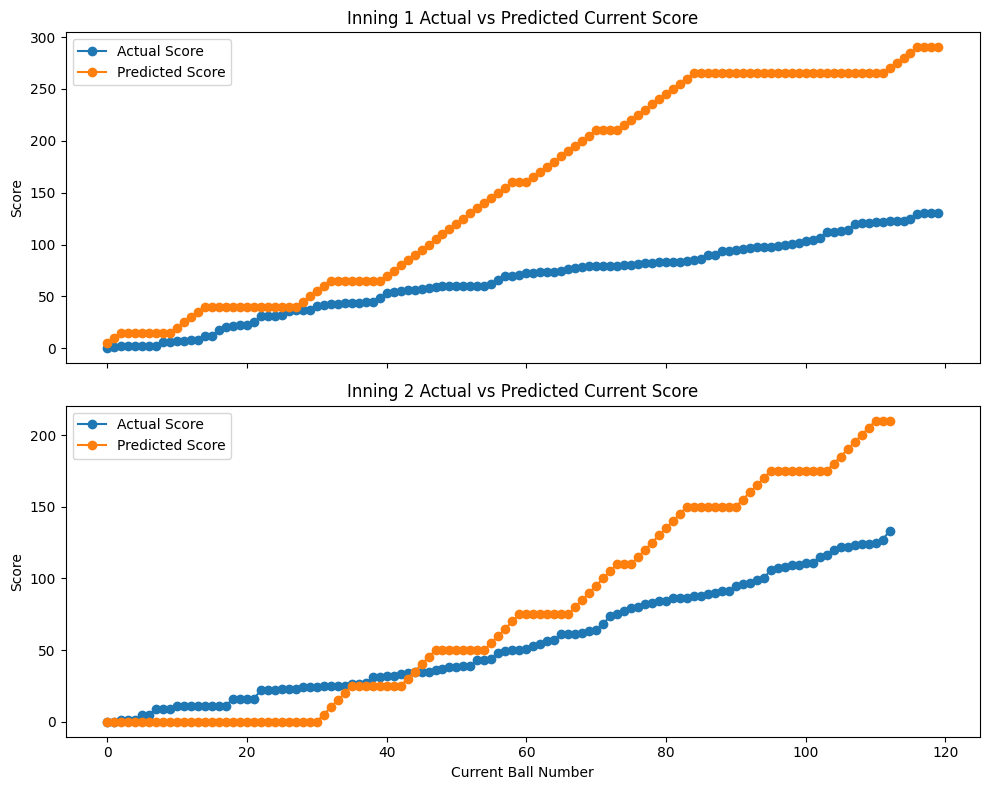

In [56]:
import matplotlib.pyplot as plt

# Separate data for each inning
inning1_data = predicted_selected_match_df[predicted_selected_match_df['innings'] == 1]
inning2_data = predicted_selected_match_df[predicted_selected_match_df['innings'] == 2]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot for Inning 1
axes[0].plot(inning1_data['current_ball_number'], inning1_data['current_score'], marker='o', label='Actual Score')
axes[0].plot(inning1_data['current_ball_number'], inning1_data['predicted_current_score'], marker='o', label='Predicted Score')
axes[0].set_ylabel('Score')
axes[0].set_title('Inning 1 Actual vs Predicted Current Score')
axes[0].legend()

# Plot for Inning 2
axes[1].plot(inning2_data['current_ball_number'], inning2_data['current_score'], marker='o', label='Actual Score')
axes[1].plot(inning2_data['current_ball_number'], inning2_data['predicted_current_score'], marker='o', label='Predicted Score')
axes[1].set_xlabel('Current Ball Number')
axes[1].set_ylabel('Score')
axes[1].set_title('Inning 2 Actual vs Predicted Current Score')
axes[1].legend()

plt.tight_layout()
plt.show()